#### Steps:

- read FoR dataset from files (easy)
- preprocess into spectrograms (hard, many decisions)
- batches & epochs (ez, padding?)
- train & val

#### How to preprocess spectrograms?

Idea: compare different approaches. VGG model only does it in a single way, maybe we can compare some input data augmentations.

Related papers:
- https://arxiv.org/pdf/1904.08779.pdf (see the tutorial NB for time & frequency masking)
- How do these different approaches affect the performance of DeepSonar?

Then, for the fake voice generator, pick the best one.

Other things to try for data loading:
- Use VGG implementation
- Use tf implementation
- Compare
- Mode = train or eval?
- pad with each batch?

Step 1: check VGG model's preprocessing vs. tf's.

In [1]:
import sys
sys.path.append('../old_code')

In [2]:
# VGG implementation lives in data_prep.py
# not sure how to install librosa on anaconda/windows...
from data_prep import load_data

In [3]:
import os
dirname = "D:/for-norm/training/real"
example = "file1.wav_16k.wav_norm.wav_mono.wav_silence.wav"

example_path = os.path.join(dirname, example)

os.path.exists(example_path), example_path

(True,
 'D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav')

In [4]:
features = load_data(example_path, mode='train')
features.shape

(257, 250)

In [5]:
features

array([[-0.27977276, -0.26520935, -0.24700199, ..., -0.23295897,
        -0.25150484, -0.26376703],
       [-0.2728357 , -0.26195452, -0.24485366, ..., -0.23702188,
        -0.25704774, -0.26484928],
       [-0.2697535 , -0.2645792 , -0.237188  , ..., -0.204933  ,
        -0.24455413, -0.26617265],
       ...,
       [-0.2820161 , -0.26862568, -0.25361684, ..., -0.2491859 ,
        -0.2632423 , -0.26922485],
       [-0.2820218 , -0.26856998, -0.25364122, ..., -0.24919383,
        -0.26338455, -0.2692693 ],
       [-0.28210023, -0.26855975, -0.25364026, ..., -0.24922384,
        -0.26334193, -0.2693363 ]], dtype=float32)

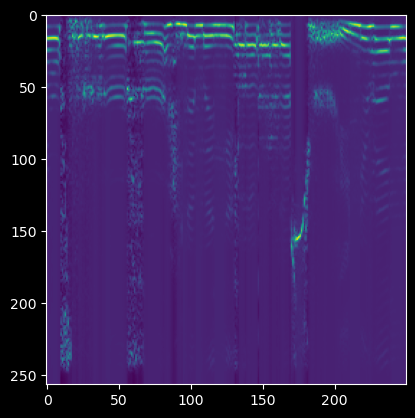

In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.imshow(features)

In [7]:
def vgg_prep(path="D:/for-norm/training/real\\file1.wav_16k.wav_norm.wav_mono.wav_silence.wav", mode="train"):
    features = load_data(example_path, mode=mode)
    plt.imshow(features)

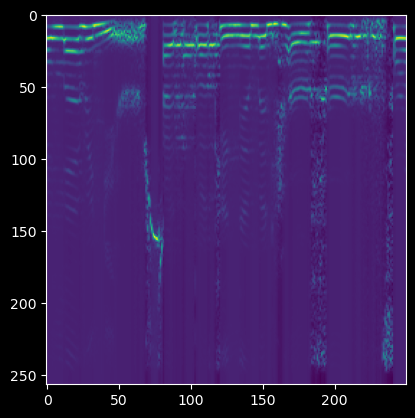

In [8]:
vgg_prep(mode='train')

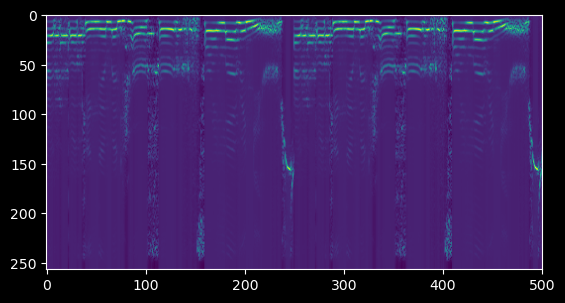

In [9]:
vgg_prep(mode='eval')

In [13]:
import tensorflow as tf
import tensorflow_io as tfio

AlreadyExistsError: File system for az already registered